# Module 4 - Trade Call Prediction using Classification

In this module, we'd be covering the concept of classification and utilize our skills to solve the following queries – (Stock Price = Close Price)

In [1]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import os
from collections import OrderedDict

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# 4.1 

Import the csv file of the stock which contained the Bollinger columns as well.

- Create a new column 'Call' , whose entries are - 
    - 'Buy' if the stock price is below the lower Bollinger band 
    - 'Hold Buy/ Liquidate Short' if the stock price is between the lower and middle Bollinger band 
    - 'Hold Short/ Liquidate Buy' if the stock price is between the middle and upper Bollinger band 
    - 'Short' if the stock price is above the upper Bollinger band

- Now train a classification model with the 3 bollinger columns and the stock price as inputs and 'Calls' as output. Check the accuracy on a test set. (There are many classifier models to choose from, try each one out and compare the accuracy for each)

- Import another stock data and create the bollinger columns. Using the already defined model, predict the daily calls for this new stock.

In [3]:
dataframe = pd.read_csv('../../data_output/module_2/week3-python.csv');
def call(row):
    if row['Close_Price'] <= row['14_day_bollinger_lower']: return 'Buy'    
    if row['Close_Price'] >= row['14_day_bollinger_upper']: return 'Short'
    if row['Close_Price'] == row['14_day_bollinger_upper']: return 'Hold'    
    if row['Close_Price'] >  row['14_day_SMA']:             return 'Hold Buy / Liquidate Short'
    if row['Close_Price'] <  row['14_day_SMA']:             return 'Hold Short / Liquidate Buy'
    
dataframe['Call'] = dataframe.apply(call, axis=1)
dataframe['Call'].unique()

array([None, 'Hold Short / Liquidate Buy', 'Hold Buy / Liquidate Short',
       'Short', 'Buy'], dtype=object)

- Now train a classification model with the 3 bollinger columns and the stock price as inputs and 'Calls' as output. Check the accuracy on a test set. (There are many classifier models to choose from, try each one out and compare the accuracy for each)

In [4]:
scaler = StandardScaler()

X = dataframe.dropna()[['Close_Price', '14_day_STD', '14_day_bollinger_upper', '14_day_bollinger_lower']]
y = dataframe.dropna()['Call']    
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

max_features = len(y.unique())

In [5]:
classifiers = OrderedDict([
    ( "Nearest Neighbors", KNeighborsClassifier(max_features) ),
    ( "Linear SVM",        SVC(kernel="linear", C=0.025) ),
    ( "RBF SVM",           SVC(gamma=2, C=1) ),
    ( "Gaussian Process",  GaussianProcessClassifier(1.0 * RBF(1.0)) ),
    ( "Decision Tree",     DecisionTreeClassifier(max_depth=5) ),
    ( "Random Forest",     RandomForestClassifier(max_depth=5, n_estimators=10, max_features=max_features) ),
    ( "Neural Net",        MLPClassifier(alpha=1, max_iter=1000) ),
    ( "AdaBoost",          AdaBoostClassifier() ),
    ( "Naive Bayes",       GaussianNB() ),
    ( "QDA",               QuadraticDiscriminantAnalysis() ),
])

In [6]:
scores = {}
for (name, classifier) in classifiers.items():
  classifier.fit(X_train, y_train)
  scores[name] = classifier.score(X_test, y_test)
    
scores = OrderedDict(sorted(scores.items(), key=lambda x: x[1]))
scores

/Users/jamie/Dropbox/Programming/aspiration-ai-internship/python3/venv/lib/python3.7/site-packages/sklearn/gaussian_process/gpc.py:434: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.83246383, -1.78573061]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/jamie/Dropbox/Programming/aspiration-ai-internship/python3/venv/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


OrderedDict([('AdaBoost', 0.41830065359477125),
             ('Gaussian Process', 0.5620915032679739),
             ('Linear SVM', 0.5686274509803921),
             ('Naive Bayes', 0.5751633986928104),
             ('QDA', 0.5816993464052288),
             ('Decision Tree', 0.6666666666666666),
             ('Random Forest', 0.7124183006535948),
             ('Nearest Neighbors', 0.7254901960784313),
             ('RBF SVM', 0.7712418300653595),
             ('Neural Net', 0.8758169934640523)])

- Import another stock data and create the bollinger columns. Using the already defined model, predict the daily calls for this new stock.

In [32]:
titan = pd.read_csv('../../data_output/module_1/python3/stocks/Large_Cap/TITAN.csv', parse_dates=['Date']);
titan.set_index('Date', drop=False)
titan["14_day_SMA"] = titan.Close_Price.rolling(14).mean()
titan["14_day_STD"] = titan.Close_Price.rolling(14).std()
titan["14_day_bollinger_upper"] = titan["14_day_SMA"] + titan["14_day_STD"] * 2
titan["14_day_bollinger_lower"] = titan["14_day_SMA"] - titan["14_day_STD"] * 2

In [68]:
titan   = titan.dropna()  # fit_transform() breaks if NA is present
titan_X = scaler.fit_transform( titan[['Close_Price', '14_day_STD', '14_day_bollinger_upper', '14_day_bollinger_lower']] )
titan['Call'] = classifiers["Neural Net"].predict( titan_X )  # using previously trained Neural Network

titan.to_csv('../../data_output/module_4/TITAN.csv');
print( "titan['Call'].unique() = ", titan['Call'].unique() )
titan.head()

titan['Call'].unique() =  ['Hold Short / Liquidate Buy' 'Hold Buy / Liquidate Short']


,Unnamed: 0,Symbol,Series,Date,Prev_Close,Open_Price,High_Price,Low_Price,Last_Price,Close_Price,...,Percent_Dly_Qt_to_Traded_Qty,Date_Year,Date_Month,Day_Perc_Change,Trend,14_day_SMA,14_day_STD,14_day_bollinger_upper,14_day_bollinger_lower,Call
13,13,TITAN,EQ,2017-06-01,474.90,475.95,476.45,465.3,468.60,470.70,...,46.16,2017,6,-0.88,Slight negative,474.917857,6.788696,488.495248,461.340466,Hold Short / Liquidate Buy
14,14,TITAN,EQ,2017-06-02,470.70,472.70,474.60,467.0,469.90,471.75,...,49.09,2017,6,0.22,Slight,474.067857,6.341518,486.750893,461.384821,Hold Short / Liquidate Buy
15,15,TITAN,EQ,2017-06-05,471.75,511.00,569.20,505.0,551.50,551.85,...,16.27,2017,6,16.98,Bull run,478.607143,21.629448,521.866039,435.348247,Hold Buy / Liquidate Short
16,16,TITAN,EQ,2017-06-06,551.85,547.00,547.10,521.4,528.75,527.15,...,25.41,2017,6,-4.48,Among top losers,481.850000,25.239065,532.328129,431.371871,Hold Buy / Liquidate Short
17,17,TITAN,EQ,2017-06-07,527.15,528.00,547.00,528.0,536.00,536.20,...,21.52,2017,6,1.72,Positive,486.460714,28.867597,544.195908,428.725521,Hold Buy / Liquidate Short


NOTES:
- MLPClassifier() = ('Neural Net', 0.8758169934640523) was the top performing Classification algroythem 
- MLPClassifier() when run on initial week3 dataset predicts examples of all 4 Call values (exceeds bollenger bands)
- MLPClassifier() when run on Titan datasets only predicts 2 out of the 4 possible Call values (eg never exceeds bollenger bands - which seems wrong)

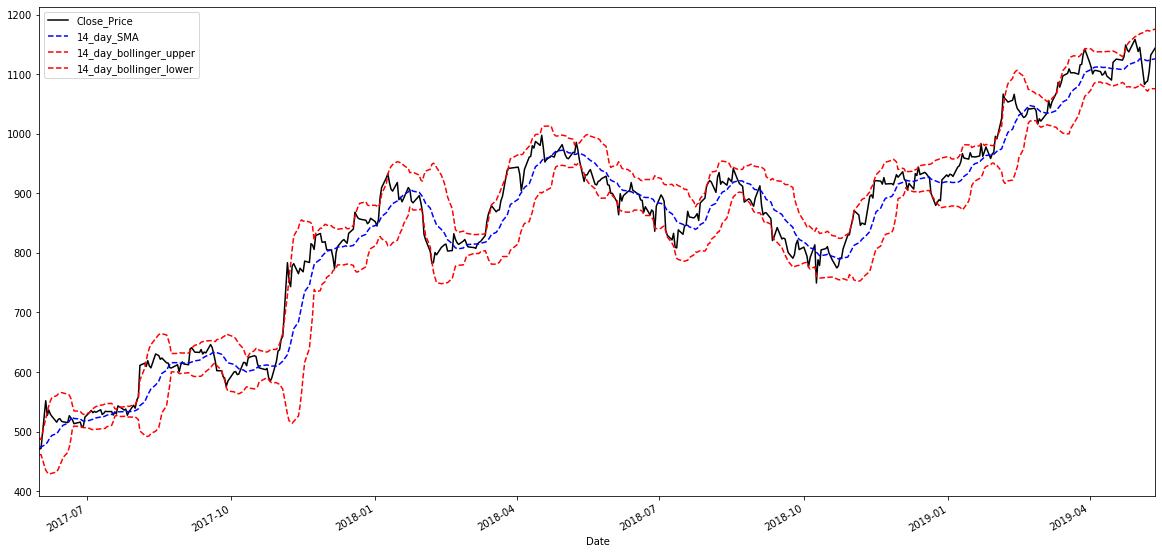

In [64]:
fig = plt.figure(figsize=(20,10))
ax  = plt.gca()

titan.plot(kind='line',x='Date', y='Close_Price',             ax=ax, color='black')
titan.plot(kind='line',x='Date', y='14_day_SMA',              ax=ax, color='blue', linestyle='--')
titan.plot(kind='line',x='Date', y='14_day_bollinger_upper',  ax=ax, color='red',  linestyle='--')
titan.plot(kind='line',x='Date', y='14_day_bollinger_lower',  ax=ax, color='red',  linestyle='--')

# 4.2 

Now, we'll again utilize classification to make a trade call, and measure the efficiency of our trading algorithm over the past two years. For this assignment , we will use RandomForest classifier.

- Import the stock data file of your choice
    - Define 4 new columns , whose values are: 
        - % change between Open and Close price for the day 
        - % change between Low and High price for the day 
        - 5 day rolling mean of the day to day % change in Close Price 
        - 5 day rolling std of the day to day % change in Close Price


    - Create a new column 'Action' whose values are: 
        - 1 if next day's price(Close) is greater than present day's. 
        - (-1) if next day's price(Close) is less than present day's. 
        - i.e. Action [ i ] = 1 if Close[ i+1 ] > Close[ i ] 
        - i.e. Action [ i ] = (-1) if Close[ i+1 ] < Close[ i ]


- Construct a classification model with the 4 new inputs and 'Action' as target

- Check the accuracy of this model , also , plot the net cumulative returns (in %) if we were to follow this algorithmic model
